In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE SINAIS (Cenário de Identificação de Sistema) ---
np.random.seed(42)
n_samples = 2000
order = 4  # M=4 seções lattice (5 coeficientes ladder)

# Entrada Correlacionada (Filtro AR)
# Filtros Lattice são famosos por "descorrelacionar" a entrada internamente
b_ar, a_ar = [1], [1, -1.4, 0.65]
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x)

# Sistema Desconhecido (Planta FIR Complexa)
w_true = np.array([1.0 + 0j, -0.6 + 0.3j, 0.4 - 0.2j, -0.2 + 0.1j, 0.1 - 0.05j])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.02 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

In [3]:
# --- 2. EXECUÇÃO DO LRLS A PRIORI ---
# lambda_factor: Próximo de 1 para sistemas estacionários
# epsilon: Regularização inicial das energias forward/backward
filt_priori = pdf.LRLSPriori(
    filter_order=order,
    lambda_factor=0.999,
    epsilon=0.01
)

result = filt_priori.optimize(x, d, verbose=True, return_internal_states=True)

[LRLSPriori] Completed in 83.87 ms


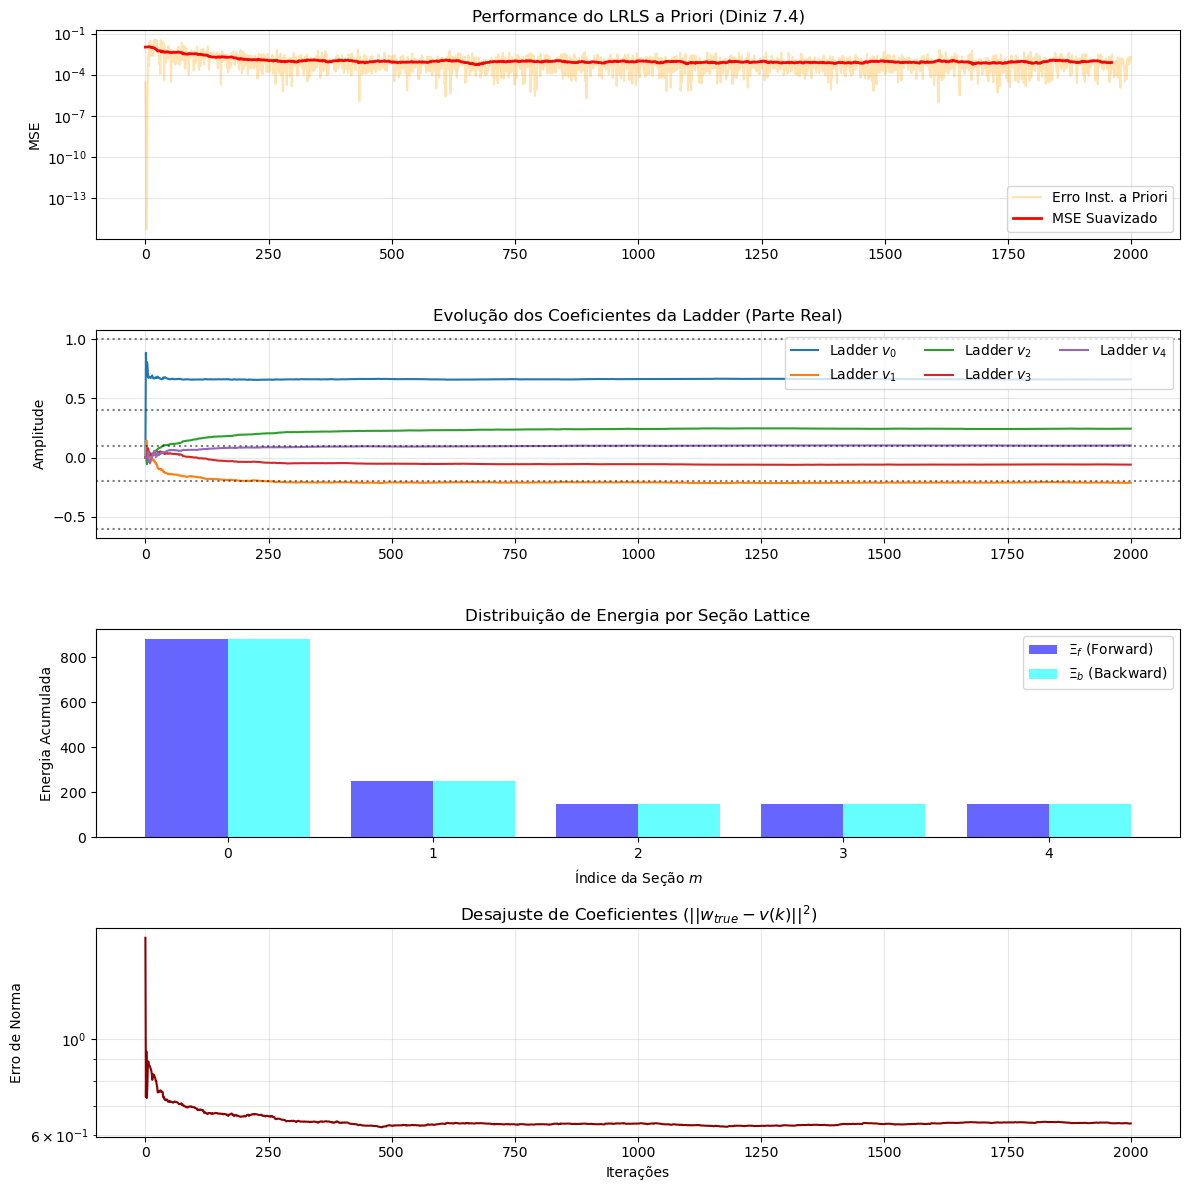

MSE Final (últimas 100 amostras): 8.610580e-04


In [4]:
# --- 3. ANÁLISE DOS RESULTADOS ---
plt.figure(figsize=(12, 12))

# Subplot 1: Erro Quadrático Médio (MSE)
plt.subplot(4, 1, 1)
plt.semilogy(result.mse(), label='Erro Inst. a Priori', alpha=0.3, color='orange')
mse_smooth = np.convolve(result.mse(), np.ones(40)/40, mode='valid')
plt.semilogy(mse_smooth, label='MSE Suavizado', color='red', lw=2)
plt.title('Performance do LRLS a Priori (Diniz 7.4)')
plt.ylabel('MSE')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes Ladder (v)
plt.subplot(4, 1, 2)
v_coeffs = np.real(result.coefficients)
for i in range(v_coeffs.shape[1]):
    plt.plot(v_coeffs[:, i], label=f'Ladder $v_{i}$')
    plt.axhline(y=np.real(w_true[i]), color='black', linestyle=':', alpha=0.5)
plt.title('Evolução dos Coeficientes da Ladder (Parte Real)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=3)

# Subplot 3: Energias Forward vs Backward (Estado Final)
plt.subplot(4, 1, 3)
xi_f = result.extra["xi_f"]
xi_b = result.extra["xi_b"]
plt.bar(np.arange(len(xi_f)) - 0.2, xi_f, width=0.4, label=r'$\Xi_f$ (Forward)', color='blue', alpha=0.6)
plt.bar(np.arange(len(xi_b)) + 0.2, xi_b, width=0.4, label=r'$\Xi_b$ (Backward)', color='cyan', alpha=0.6)
plt.title('Distribuição de Energia por Seção Lattice')
plt.xlabel('Índice da Seção $m$')
plt.ylabel('Energia Acumulada')
plt.legend()

# Subplot 4: Erro de Desajuste (Mismatch)
plt.subplot(4, 1, 4)
mismatch = np.linalg.norm(result.coefficients - w_true, axis=1)**2
plt.semilogy(mismatch, color='darkred')
plt.title('Desajuste de Coeficientes ($||w_{true} - v(k)||^2$)')
plt.ylabel('Erro de Norma')
plt.xlabel('Iterações')
plt.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Final (últimas 100 amostras): {np.mean(result.mse()[-100:]):.6e}")